In [1]:
import pandas as pd
import io
import requests
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt

In [2]:
train_url = "http://www.amlbook.com/data/zip/features.train"
test_url = "http://www.amlbook.com/data/zip/features.test"

In [3]:
def URL_to_dataframe(url):
    s = requests.get(url).content
    c = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None, delim_whitespace=True)
    
    return c

In [4]:
def scaling(all_feature, train_number):
    intensity = np.interp(all_feature[:,0],(all_feature[:,0].min(), all_feature[:,0].max()), (0,1))
    symmetry = np.interp(all_feature[:,1],(all_feature[:,1].min(), all_feature[:,1].max()), (0,1))
    print(intensity.shape)
    print(symmetry.shape)
    processed = np.concatenate((intensity.reshape(-1,1), symmetry.reshape(-1,1)), axis=1)
    
    return processed[:train_number,:], processed[train_number:,:]

In [5]:
def binary_label(label, target_label):
    target_position = (label==target_label)
    label = label*0
    label[target_position] = 1
    
    return label

In [6]:
def get_weight(y_alpha, SVs, dim):
    y_alpha = y_alpha.reshape(-1,1)
    weight_matrix = np.zeros((y_alpha.shape[0], dim))
    weight_matrix[:,0] = 1.0
    for i in range(SVs.shape[0]):
        weight_matrix[i,1:dim] = SVs[i,0:dim]
    
    weight_sv = y_alpha * weight_matrix
    weight = np.sum(weight_sv, axis=0)
    
    return weight

In [7]:
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.sum((x1-x2)**2))

In [8]:
train_df = URL_to_dataframe(train_url)
test_df = URL_to_dataframe(test_url)

In [9]:
train_np = train_df.to_numpy()
test_np = test_df.to_numpy()

In [10]:
train_feature = train_np[:,1:3]
train_label = train_np[:,0]
test_feature = test_np[:,1:3]
test_label = test_np[:,0]

In [11]:
print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

(7291, 2)
(7291,)
(2007, 2)
(2007,)


In [12]:
train_label = binary_label(train_label, 0)
test_label = binary_label(test_label, 0)

In [13]:
# 14
c_list = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
log10c_list = [-3, -2, -1, 0, 1]
Margin_length_list = []

for c in c_list:
    print(c)
    clf = svm.SVC(C=c, kernel='rbf', gamma= 80)
    clf.fit(train_feature, train_label)
    SVs = clf.support_vectors_
    sv = clf.support_vectors_[0].reshape(-1,2)
    w_norm = np.linalg.norm(clf.dual_coef_)
    Margin_length_list.append(abs(clf.decision_function(sv))/w_norm)

0.001
0.01
0.1
1.0
10.0


Text(0, 0.5, 'distance of any free support vector to the hyperplan')

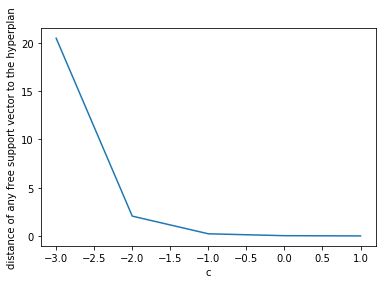

In [14]:
plt.plot(log10c_list, Margin_length_list)
plt.xlabel('c')
plt.ylabel('distance of any free support vector to the hyperplan')

In [15]:
# 14'
c_list = [1e-3, 1e-2, 1e-1, 1e0, 1e1]
log10c_list = [-3, -2, -1, 0, 1]
Margin_length_list = []

for c in c_list:
    print(c)
    clf = svm.SVC(C=c, kernel='rbf', gamma= 80)
    clf.fit(train_feature, train_label)
    SVs_feature = clf.support_vectors_
    SVs_label = train_label[clf.support_]
    alpha = np.abs(clf.dual_coef_.reshape(-1))
    w_square = 0.0 
    for i in range(len(alpha)):
        for j in range(len(alpha)):
            w_square += alpha[i] * alpha[j] * SVs_label[i] * SVs_label[j] * rbf_kernel(train_feature[i], train_feature[j], 80)
    Margin_length_list.append(1. / np.sqrt(w_square))

0.001
0.01
0.1
1.0
10.0


Text(0, 0.5, 'distance of any free support vector to the hyperplan')

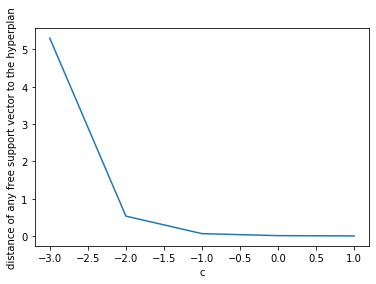

In [16]:
plt.plot(log10c_list, Margin_length_list)
plt.xlabel('c')
plt.ylabel('distance of any free support vector to the hyperplan')

In [17]:
# 15
gamma_list = [1e0, 1e1, 1e2, 1e3, 1e4]
log10_gamma_list = [0, 1, 2, 3, 4]
Eout_list = []

for gamma in gamma_list:
    clf = svm.SVC(C=0.1, kernel='rbf', gamma=gamma)
    clf.fit(train_feature, train_label)
    
    Eout_list.append(1.0 - clf.score(test_feature, test_label))

Text(0, 0.5, 'Eout')

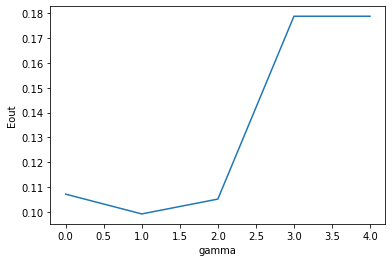

In [18]:
plt.plot(log10_gamma_list, Eout_list)
plt.xlabel('gamma')
plt.ylabel('Eout')

In [19]:
# 16
gamma_list = [1e-1, 1e0, 1e1, 1e2, 1e3]
log10_gamma_list = [-1, 0, 1, 2, 3]
best_log10_gamma = []

for i in range(100):
    print("iter", i)
    permutation = np.random.permutation(train_feature.shape[0]) - 1
    train_permutation = permutation[1000:]
    val_permutation = permutation[:1000]
    
    temp_train_feature = train_feature[train_permutation]
    temp_train_label = train_label[train_permutation]
    val_feature = train_feature[val_permutation]
    val_label = train_label[val_permutation]

    highest_acc = 0
    highest_gamma = 0
    for j in range(5):
        clf = svm.SVC(C=0.1, kernel='rbf', gamma=gamma_list[j])
        clf.fit(temp_train_feature, temp_train_label)
        temp_acc = clf.score(val_feature, val_label)
        
        if temp_acc > highest_acc:
            highest_acc = temp_acc
            highest_gamma = log10_gamma_list[j]
    best_log10_gamma.append(highest_gamma)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
iter 70
iter 71
iter 72
iter 73
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
iter 94
iter 95
iter 96
iter 97
iter 98
iter 99


In [21]:
print(best_log10_gamma)
best_log10_gamma = best_log10_gamma

[1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]


In [22]:
data = {}
for log10c in log10_gamma_list:
    temp = best_log10_gamma.count(log10c)
    data[str(log10c)] = temp

In [23]:
print(data)

{'-1': 0, '0': 6, '1': 79, '2': 15, '3': 0}


Text(0.5, 0.98, 'Categorical Plotting')

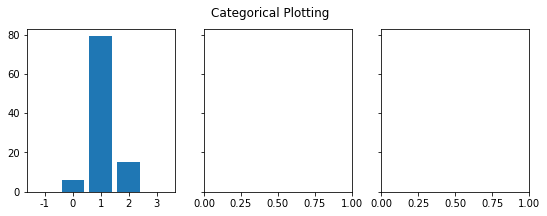

In [24]:
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)

fig.suptitle('Categorical Plotting')